In [9]:
import random

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt

%matplotlib inline


class SchellingAgent(Agent):
    '''
    Schelling segregation agent
    '''
    def __init__(self, pos, model, agent_type):
        '''
         Create a new Schelling agent.
         Args:
            unique_id: Unique identifier for the agent.
            x, y: Agent initial location.
            agent_type: Indicator for the agent's type (minority=1, majority=0)
        '''
        Agent.__init__(self, pos, model) 
        self.pos = pos
        self.type = agent_type

    def step(self):
        similar = 0
        for neighbor in self.model.grid.neighbor_iter(self.pos):
            if neighbor.type == self.type:
                similar += 1

        # If unhappy, move:
        if similar < self.model.homophily:
            self.model.grid.move_to_empty(self)
        else:
            self.model.happy += 1


class SchellingModel(Model):
    '''
    Model class for the Schelling segregation model.
    '''

    def __init__(self, height, width, density, minority_pc, homophily):
        '''
        '''

        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.homophily = homophily

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=True)

        self.happy = 0
        self.datacollector = DataCollector(
            {"happy": lambda m: m.happy},  # Model-level count of happy agents
            # For testing purposes, agent's individual x and y
            {"x": lambda a: a.pos[0], "y": lambda a: a.pos[1]})

        self.running = True

        # Set up agents
        # We use a grid iterator that returns
        # the coordinates of a cell as well as
        # its contents. (coord_iter)
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if random.random() < self.density:
                if random.random() < self.minority_pc:
                    agent_type = 1
                else:
                    agent_type = 0

                agent = SchellingAgent((x, y), self, agent_type)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        self.happy = 0  # Reset counter of happy agents
        self.schedule.step()
        self.datacollector.collect(self)

        if self.happy == self.schedule.get_agent_count():
            self.running = False


In [10]:
model = SchellingModel(10, 10, 0.8, 0.2, 3)


In [11]:
while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps) # Show how many steps have actually run


100


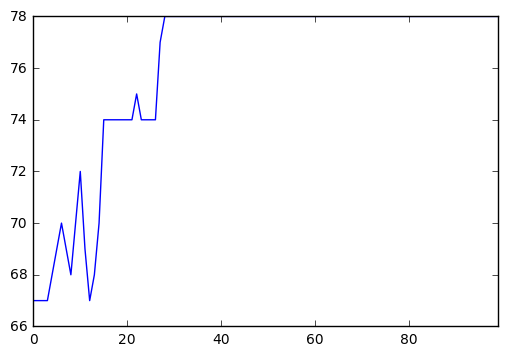

In [8]:
model_out = model.datacollector.get_model_vars_dataframe()
model_out.happy.plot()
